# Analyses de contributions

Nous allons réaliser sur notre exemple de béton armé les différentes analyses de contributions vues en cours. Pour rappel, nous nous appuyons sur l'article de van der Meide et al., 2025 (https://link.springer.com/article/10.1007/s11367-025-02487-y#Sec46).

Le procédé étudié a été défini au TD2, il s'agit de la production d'1 m3 de béton armé type A.

Béton | Flux | Procédé choisi dans ecoinvent | Région | Unité | Qté pour 1m3
:---: | :---: | :---: | :---: | :---: | :---:
Béton A | ciment Portland | market for cement, Portland | Europe without Switzerland | kg | 350
Béton A | eau | market for tap water | Europe without Switzerland | kg | 175
Béton A | sable | market for sand | Rest-of-World (RoW) | kg | 800 
Béton A | graviers | market for gravel, crushed | Rest-of-World (RoW) | kg | 1100
Béton A | ferraillage | market for reinforcing steel | Global | kg | 100
Béton A | énergie | diesel, burned in building machine | Global | MJ | 14.4

In [5]:
import bw2io as bi # ensemble des fonctions et classes pour importer et exporter (input/output)
import bw2data as bd # ... pour gérer les données du projet
import bw2calc as bc # ... pour faire des opérations
import bw2analyzer as ba # ... pour interpréter les résultats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bd.projects.set_current('project_ecoinvent_311')
eidb = bd.Database('ecoinvent-3.11-cutoff')
biodb = bd.Database('ecoinvent-3.11-biosphere')
fgdb = bd.Database('betons_armes')

beton_A = fgdb.search("Béton A")[0] # le procédé de béton armé
meth = [m for m in bd.methods if 'EF v3.1' in m[1] and 'no LT' not in m[1]] # la méthode de caractérisation choisie (EF v3.1)

Dans cette séance, nous allons nous intéresser à l'indicateur de potentiel de réchauffement climatique à 100 ans, que l'on isole donc dans une variable.

In [6]:
gwp100 = [ind for ind in meth if 'GWP100' in str(ind) and 'biogenic' not in str(ind) and 'fossil' not in str(ind) and 'land' not in str(ind)][0]

## AC directe

### Calcul de la matrice de contribution

Afin de réaliser des analyses de contribution directes, on calcule dans ce qui suit des matrices de contribution. Pour cela, on réalise l'ACV du béton A :

In [7]:
lca = bc.LCA(demand = {beton_A : 1.0},method= gwp100)
lca.lci()
lca.lcia()
s=lca.score
s

561.9650284777496

In [8]:
contrib_mat = lca.characterized_inventory # On récupère la matrice d'inventaire caractérisé de brightway, qui est la matrice de contribution
print(contrib_mat)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21263 stored elements and shape (3238, 25414)>
  Coords	Values
  (50, 19)	0.001901927209229191
  (50, 21)	6.20746862195061e-09
  (50, 24)	4.9279061320232555e-08
  (50, 32)	1.5864507077406081e-12
  (50, 43)	2.2300179470300972e-09
  (50, 55)	1.2703435978890022e-05
  (50, 112)	0.0003585349218767429
  (50, 132)	2.857654993571739e-08
  (50, 162)	4.408490283245267e-08
  (50, 189)	6.137209330793502e-13
  (50, 190)	5.433001641514236e-06
  (50, 192)	1.2276745682390134e-06
  (50, 198)	0.0008725178463754893
  (50, 261)	1.6714003981923617e-07
  (50, 262)	2.1739237853539014e-07
  (50, 301)	1.0498203910377178e-11
  (50, 369)	9.642984572574064e-07
  (50, 373)	1.5675783943245034e-06
  (50, 406)	1.0065167349594494e-08
  (50, 464)	1.9634661635161854e-28
  (50, 557)	6.408464879438747e-08
  (50, 559)	1.2130102890067385e-07
  (50, 560)	4.76687856011525e-09
  (50, 570)	8.500101183330287e-08
  (50, 595)	0.00011232199826911414
  :	:
  (3214, 11300)

### AC des flux élémentaires désagrégés

 AC de chaque flux élémentaire de chaque procédé à l'indicateur étudié

On affiche d'abord un tableau de contribution avec un cut-off à 1% :

In [9]:
# fonction intégrée de brightway qui range les résultats dans un tableau
h_df = lca.to_dataframe(
    matrix_label='characterized_inventory', # on veut les valeurs de la matrice de contribution
    cutoff_mode='fraction', # on va utiliser un cut-off qui sera une fraction du score d'impact
    cutoff=0.01 # on réalise le cut off à 1%
    )

h_df.insert(loc=3,column='relativ_amount',value=h_df['amount']/s)
h_df.insert(loc=4,column='cell_name',value=h_df['row_name'] + "-" + h_df['col_name'])

h_df

,row_index,col_index,amount,relativ_amount,cell_name,row_id,col_id,row_database,row_code,row_name,...,row_type,row_categories,row_product,col_database,col_code,col_name,col_location,col_unit,col_type,col_reference_product
0,2013,1241,265.455018,0.472369,"Carbon dioxide, fossil-clinker production",227399215048876087,227399378819670016,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",...,emission,air,None,ecoinvent-3.11-cutoff,8e4525e15e1bcd4c996adccc11207e95,clinker production,Europe without Switzerland,kilogram,processwithreferenceproduct,clinker
1,2013,17448,60.681004,0.107980,"Carbon dioxide, fossil-pig iron production",227399215048876087,227399506171322368,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",...,emission,air,None,ecoinvent-3.11-cutoff,5ed052d5f3b313699d3bfeeee056360a,pig iron production,RoW,kilogram,processwithreferenceproduct,pig iron
2,2013,1353,18.295654,0.032557,"Carbon dioxide, fossil-iron sinter production",227399215048876087,227399379423649792,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",...,emission,air,None,ecoinvent-3.11-cutoff,f643e40b24c5f097085bf500b33b8cdc,iron sinter production,RoW,kilogram,processwithreferenceproduct,iron sinter
3,3190,8832,10.899428,0.019395,"Methane, fossil-natural gas venting from petro...",227399215422169127,227399438651416582,ecoinvent-3.11-biosphere,70ef743b-3ed5-4a6d-b192-fb6d62378555,"Methane, fossil",...,emission,air::non-urban air or from high stacks,None,ecoinvent-3.11-cutoff,b82b51343d199a7aa291b3d26d26d6b1,natural gas venting from petroleum/natural gas...,GLO,cubic meter,processwithreferenceproduct,"natural gas, vented"
4,659,23068,8.639141,0.015373,"Carbon dioxide, fossil-quicklime production, i...",227399214625251401,227399544641478656,ecoinvent-3.11-biosphere,aa7cac3a-3625-41d4-bc54-33e2cf11ec46,"Carbon dioxide, fossil",...,emission,air::non-urban air or from high stacks,None,ecoinvent-3.11-cutoff,cfe71326bd6404f1fe1d8f7379891a58,"quicklime production, in pieces, loose",RoW,kilogram,processwithreferenceproduct,"quicklime, in pieces, loose"
5,2013,23138,8.014009,0.014261,"Carbon dioxide, fossil-diesel, burned in build...",227399215048876087,227399544951857152,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",...,emission,air,None,ecoinvent-3.11-cutoff,2c5b29553298fe78ac40d6253ddca452,"diesel, burned in building machine",GLO,megajoule,processwithreferenceproduct,"diesel, burned in building machine"
6,2013,1628,7.318437,0.013023,"Carbon dioxide, fossil-pig iron production",227399215048876087,227399381541773312,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",...,emission,air,None,ecoinvent-3.11-cutoff,1a5f3a33cdad3b88f159e63f38715f7c,pig iron production,RER,kilogram,processwithreferenceproduct,pig iron
7,3190,2664,6.925600,0.012324,"Methane, fossil-hard coal mine operation and h...",227399215422169127,227399388743393280,ecoinvent-3.11-biosphere,70ef743b-3ed5-4a6d-b192-fb6d62378555,"Methane, fossil",...,emission,air::non-urban air or from high stacks,None,ecoinvent-3.11-cutoff,b2f165abc65c44f0fc255b2b852bc1be,hard coal mine operation and hard coal prepara...,CN,kilogram,processwithreferenceproduct,hard coal
8,2489,8546,6.336005,0.011275,"Carbon dioxide, fossil-heat production, at har...",227399215204065380,227399436294217729,ecoinvent-3.11-biosphere,f9749677-9c9f-4678-ab55-c607dfdc2cb9,"Carbon dioxide, fossil",...,emission,air::urban air close to ground,None,ecoinvent-3.11-cutoff,1ec8ef47e1fae8ca2b8d0254edb9f6f1,"heat production, at hard coal industrial furna...",RoW,megajoule,processwithreferenceproduct,"heat, district or industrial, other than natur..."
9,659,20980,6.171049,0.010981,"Carbon dioxide, fossil-coke production, wet qu...",227399214625251401,227399528673763328,ecoinvent-3.11-biosphere,aa7cac3a-3625-41d4-bc54-33e2cf11ec46,"Carbon dioxide, fossil",...,emission,air::n

#### Exercice

Notre cut-off est-il suffisamment bas pour que notre tableau de flux élémentaires soit à peu près exhaustif sur les contributeurs ? 


#### Correction

On peut sommer les contributions des flux du tableau et les comparer au score total :

In [10]:
reste = s-sum(h_df['amount'])
print("Le score d'impact total est de",f"{s:.0f}\n",f"La somme des contributions inférieures au cut-off est de {reste:.0f}, soit {reste*100/s :.0f}% du score total")


Le score d'impact total est de 562
 La somme des contributions inférieures au cut-off est de 163, soit 29% du score total


#### Suite du TD

On peut désormais tracer les contributions des flux élémentaires désagrégés à l'indicateur :

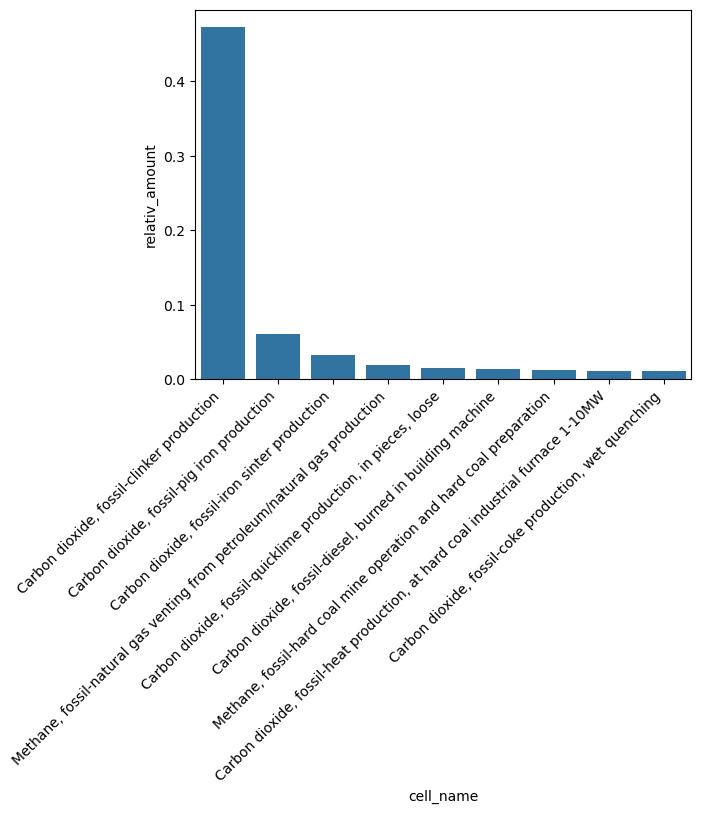

In [11]:
fig, ax = plt.subplots()
sns.barplot(data=h_df,x = 'cell_name',y = 'relativ_amount',errorbar=None)

plt.xticks(rotation=45, ha='right');


### AC des flux élémentaires agrégés

AC des flux élémentaires agrégés sur l'ensemble des procédés

On stocke la matrice de contribution dans une variable et on regarde à quoi elle ressemble :

In [12]:
contrib_mat =lca.characterized_inventory # matrice d'inventaire caractérisé ie matrice de contribution
print(contrib_mat)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21263 stored elements and shape (3238, 25414)>
  Coords	Values
  (50, 19)	0.001901927209229191
  (50, 21)	6.20746862195061e-09
  (50, 24)	4.9279061320232555e-08
  (50, 32)	1.5864507077406081e-12
  (50, 43)	2.2300179470300972e-09
  (50, 55)	1.2703435978890022e-05
  (50, 112)	0.0003585349218767429
  (50, 132)	2.857654993571739e-08
  (50, 162)	4.408490283245267e-08
  (50, 189)	6.137209330793502e-13
  (50, 190)	5.433001641514236e-06
  (50, 192)	1.2276745682390134e-06
  (50, 198)	0.0008725178463754893
  (50, 261)	1.6714003981923617e-07
  (50, 262)	2.1739237853539014e-07
  (50, 301)	1.0498203910377178e-11
  (50, 369)	9.642984572574064e-07
  (50, 373)	1.5675783943245034e-06
  (50, 406)	1.0065167349594494e-08
  (50, 464)	1.9634661635161854e-28
  (50, 557)	6.408464879438747e-08
  (50, 559)	1.2130102890067385e-07
  (50, 560)	4.76687856011525e-09
  (50, 570)	8.500101183330287e-08
  (50, 595)	0.00011232199826911414
  :	:
  (3214, 11300)

On peut maintenant sommer les lignes et/ou les colonnes de la matrice pour agréger les contributions par flux élémentaire et/ou procédé.

In [13]:
contrib_EF = contrib_mat.sum(axis=1) # On fait la somme de chacune des lignes pour avoir la contribution des EF agrégés sur l'ensemble des procédés
print(f"Dimensions de la matrice : {contrib_EF.shape}")
print(f"Somme des éléments de la matrice : {contrib_EF[:,0].sum() : .0f}") # On vérifie que la somme des éléments vaut bien le score total
nodes = [bd.get_node(id = i) for i in lca.dicts.biosphere.keys()] # On crée la liste des noeuds (flux élémentaires) à partir de leurs indices
contrib_EF_dict = {str(nodes[i]):float(contrib_EF[i,0]) for i in range(len(nodes))} # On crée un dictionnaire avec le nom des EF pour clés et la contribution en valeur
print(f"Somme des éléments du dictionnaire : {sum(contrib_EF_dict.values()) : .0f}") # On vérifie que la somme des éléments vaut bien le score total

Dimensions de la matrice : (3238, 1)
Somme des éléments de la matrice :  562
Somme des éléments du dictionnaire :  562


On peut désormais tracer les contributions, en se fixant un cut-off :

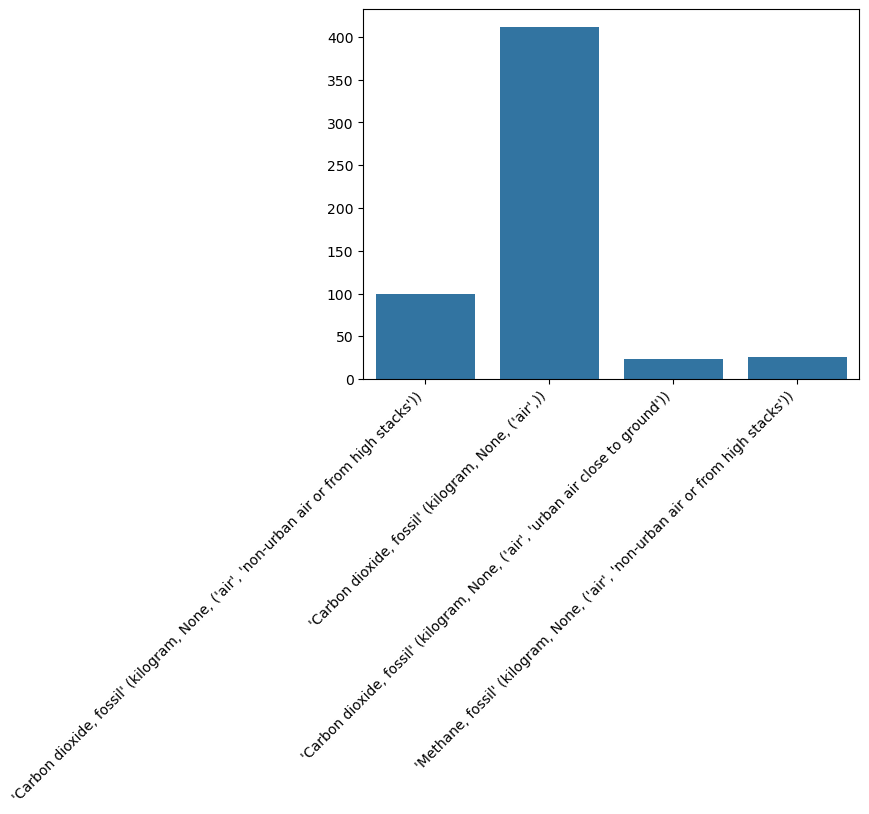

In [42]:
cutoff = 0.01 # en pourcentage du score d'impact
fig, ax = plt.subplots()
sns.barplot( { k : v for k,v in contrib_EF_dict.items() if v > s*cutoff},errorbar=None) # On fait ici une compréhension de dictionnaire pour ne tracer que les valeurs au dessus du cut-off
plt.xticks(rotation=45, ha='right');

In [46]:
reste = s-sum({ k : v for k,v in contrib_EF_dict.items() if v > s*cutoff}.values())
print("reste : ",reste,"\n", "reste relatif : ", reste/s) 

reste :  2.90896666587048 
 reste relatif :  0.005176419382804455


On peut se donner un élément de comparaison : 

Regardons la masse de méthane dans notre inventaire et comparons le produit de celle-ci avec un facteur de caractérisation usuel (~29 kgCO2 eq / kg CH4). On veut vérifier que le score d'impact calculé correspond à une caractérisation "faite à la main".

Pour trouver la masse, on fait le même travail que précédemment, mais avec la matrice d'inventaire et non de contribution.

In [15]:
G =lca.inventory # matrice d'inventaire

G_EF = G.sum(axis=1) # On fait la somme de chacune des lignes pour avoir la contribution à l'inventaire des EF agrégés sur l'ensemble des procédés
nodes = [bd.get_node(id = i) for i in lca.dicts.biosphere.keys()] # On crée la liste des noeuds () à partir de leur indice
G_EF = {str(nodes[i]) : float(G_EF[i,0]) for i in range(len(nodes))} # On crée un dictionnaire avec le nom des EF pour clés et la contribution en valeur
G_EF = { k : v for k,v in G_EF.items() if v!=0} # On supprime les valeurs nulles

On affiche désormais toutes les quantités de méthane de notre inventaire :

In [16]:
methanes = {k : G_EF[k] for k in G_EF.keys() if 'Methane' in str(k)}
print(methanes)
contrib_methanes = {k : contrib_EF_dict[k] for k in contrib_EF_dict.keys() if 'Methane' in str(k)}
methanes

{"'Methane, fossil' (kilogram, None, ('air',))": 0.014280051643986729, "'Methane, from soil or biomass stock' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 4.818131610234271e-05, "'Methane, non-fossil' (kilogram, None, ('air', 'urban air close to ground'))": 0.0001439893082704479, "'Methane, non-fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 0.006707761332198815, "'Methanesulfonic acid' (kilogram, None, ('air', 'urban air close to ground'))": 6.141556213275486e-10, "'Methane, non-fossil' (kilogram, None, ('air',))": 5.8542910502624035e-06, "'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground'))": 0.00693347953674511, "'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 0.8529966877286831}


{"'Methane, fossil' (kilogram, None, ('air',))": 0.014280051643986729,
 "'Methane, from soil or biomass stock' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 4.818131610234271e-05,
 "'Methane, non-fossil' (kilogram, None, ('air', 'urban air close to ground'))": 0.0001439893082704479,
 "'Methane, non-fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 0.006707761332198815,
 "'Methanesulfonic acid' (kilogram, None, ('air', 'urban air close to ground'))": 6.141556213275486e-10,
 "'Methane, non-fossil' (kilogram, None, ('air',))": 5.8542910502624035e-06,
 "'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground'))": 0.00693347953674511,
 "'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 0.8529966877286831}

In [17]:
masse_methane = sum(methanes.values())
CF_usuel = 29
resultat_coindetable = masse_methane*CF_usuel
resultat_brightway = sum(contrib_methanes.values())
print('coin de table : ',resultat_coindetable,'\n','brightway : ',resultat_brightway)

coin de table :  25.55236416736458 
 brightway :  26.23805499286522


Le résultat attendu est proche de celui obtenu. Vérifions le facteur de caractérisation utilisé par Brightway pour notre méthode.

In [18]:
methane_ids = {node : node.id for node in biodb if node['name'] == 'Methane, fossil' } # On regarde l'indice des noeuds correspondant au méthane
methane_ids


{'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground')): 227399215350865941,
 'Methane, fossil' (kilogram, None, ('air',)): 227399214520393764,
 'Methane, fossil' (kilogram, None, ('air', 'low population density, long-term')): 227399215149539448,
 'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')): 227399215422169127}

In [19]:
C = lca.characterization_matrix # On regarde dans la matrice de caractérisation la valeur qui nous intéresse
C[lca.dicts.biosphere[list(methane_ids.values())[3]],lca.dicts.biosphere[list(methane_ids.values())[3]]]


29.799999237060547

### AC des procédés

Pour trouver la contribution directe de chacun des procédés, la démarche est exactement la même, mais en agrégeant suivant les colonnes.

In [20]:
contrib_process = contrib_mat.sum(axis=0)
print(f"Dimensions de la matrice : {contrib_process.shape}")
print(f"Somme des éléments de la matrice : {contrib_process[0,:].sum() : .0f}") # On vérifie que la somme des éléments vaut bien le score total
nodes = [bd.get_node(id = i) for i in lca.dicts.activity.keys()] # On crée la liste des noeuds (ici des procédés) à partir de leurs indices
contrib_process_dict = {nodes[i]:float(contrib_process[0,i]) for i in range(len(nodes))} # On crée un dictionnaire avec le nom des procédés pour clés et la contribution en valeur
print(f"Somme des éléments du dictionnaire : {sum(contrib_EF_dict.values()) : .0f}") # On vérifie que la somme des éléments vaut bien le score total

Dimensions de la matrice : (1, 25414)
Somme des éléments de la matrice :  562
Somme des éléments du dictionnaire :  562


On peut désormais tracer les contributions, en se fixant un cut-off :

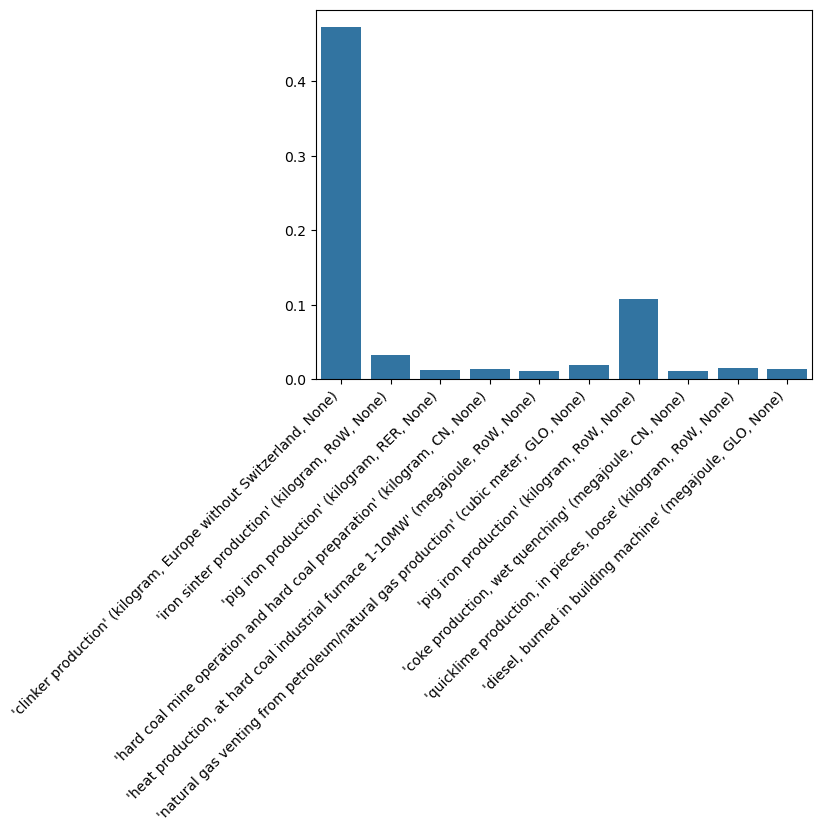

In [33]:
cutoff = 0.01 # en pourcentage du score d'impact
fig, ax = plt.subplots()
sns.barplot( { k : v/s for k,v in contrib_process_dict.items() if v > s*cutoff},errorbar=None) # On fait ici une compréhension de dictionnaire pour ne tracer que les valeurs au dessus du cut-off
plt.xticks(rotation=45, ha='right');

### AC de groupes de procédés

On peut grouper les procédés et évaluer la contribution directe de ces groupes aux indicateurs d'impacts. Le crtière pour les grouper est libre, il est courant de regrouper les procédés par étape du cycle de vie, ou par secteur de l'économie.

On commence par reprendre le dicitonnaire des contributions par procédés, et on agrège selon le critère du secteur économique.

In [22]:
filtered_contrib_process_dict = { k : v for k,v in contrib_process_dict.items() if 'classifications' in list(k.keys())} # On ne garde que les activités qui ont une classification (deux activités posent problèmes seulement)
sectors = set([act['classifications'][0][1] for act in list(filtered_contrib_process_dict.keys())]) # On détermine l'ensemble des secteurs, avec une fois chaque secteur
contrib_sectors = {sector : sum([i[1] for i in filtered_contrib_process_dict.items() if i[0]['classifications'][0][1]==sector]) for sector in sectors} # Pour chaque secteur, on somme la liste des contributions qui en font partie

On vérifie que la somme des contributions vaut le score total :

In [23]:
print(f"Somme des éléments du dictionnaire : {sum(contrib_sectors.values()) : .0f}")

Somme des éléments du dictionnaire :  562


On peut désormais tracer les contributions, en se fixant un cut-off :

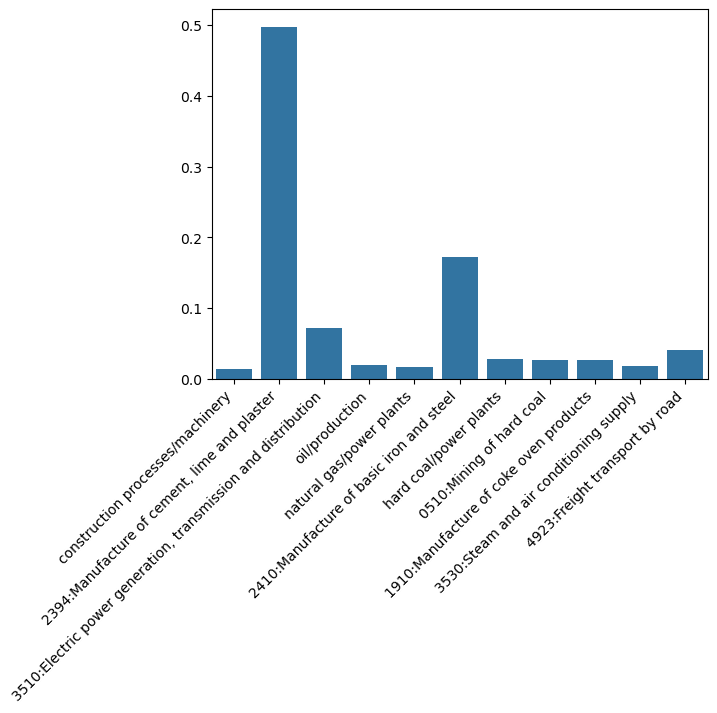

In [34]:
cutoff = 0.01 # en pourcentage du score d'impact

fig, ax = plt.subplots()
sns.barplot( { k : v/s for k,v in contrib_sectors.items() if v > s*cutoff},errorbar=None) # On fait ici une compréhension de dictionnaire pour ne tracer que les valeurs au dessus du cut-off
plt.xticks(rotation=45, ha='right');

Nous nous sommes ici servis du fait que les secteurs de l'économie sont une donnée présente dans les procédés ecoinvent. Si vous souhaitez grouper les activités que vous créez par étapes du cycle de vie, pensez à l'indiquer en métadonnées, dans un champ que vous pouvez créer, ou bien faite des macro-procédés par étape de cycle de vie.

## AC indirecte

### AC des procédés de premier niveau

Pour avoir les contributions des procédés de premier niveau, on réalise successivement l'ACV de chacun d'eux. On récupère donc les activités avec lesquelles notre béton a des échanges (flux intermédiaires).

In [25]:
first_tier_processes ={p.input : p.amount for p in list(beton_A.technosphere())} # On récupère les identifiants des procédés et la valeurs de flux intermédiaires associés

In [26]:
contrib_first_processes = {}
for p,a in first_tier_processes.items() :
    lca = bc.LCA(demand={p : a},method=gwp100)
    lca.lci()
    lca.lcia()
    contrib_first_processes[p['name']] = lca.score

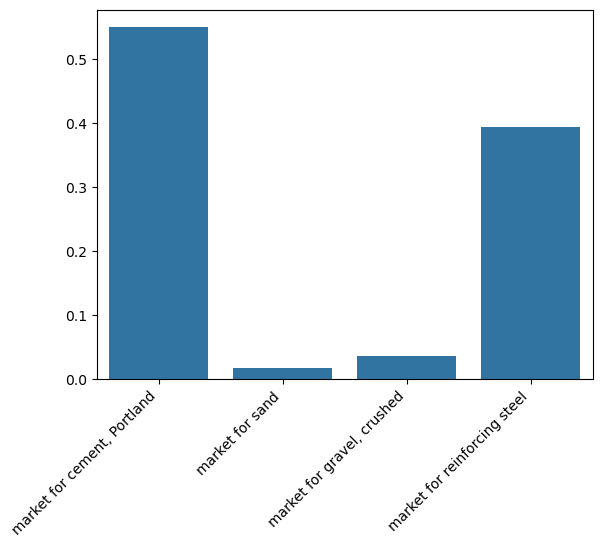

In [29]:
cutoff = 0.005 # en pourcentage du score d'impact

fig, ax = plt.subplots()
sns.barplot( { k : v/s for k,v in contrib_first_processes.items() if v > s*cutoff},errorbar=None) # On fait ici une compréhension de dictionnaire pour ne tracer que les valeurs au dessus du cut-off
plt.xticks(rotation=45, ha='right');

Et si on changeait le cut-off ?

On peut également tracer un diagramme en barres empilées :

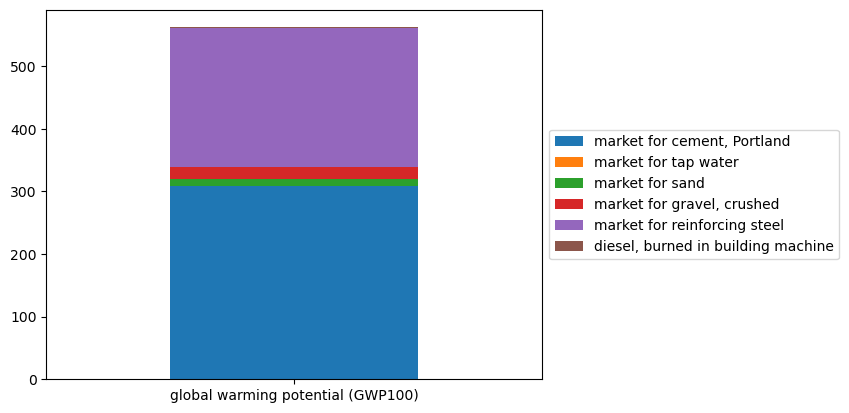

In [28]:
df_first_processes = pd.DataFrame(contrib_first_processes,index=[str(gwp100[-1])])
df_first_processes.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0, ha='center');